# DeepWalk
- updating method : softmax

# 1. Import Dataset 

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from random import shuffle
from copy import copy

%matplotlib inline

In [2]:
edge = pd.read_csv('karate_club.edgelist', sep=' ', names=['x','y','w'])

In [3]:
edge.head()

,x,y,w
0,0,1,{}
1,0,2,{}
2,0,3,{}
3,0,4,{}
4,0,5,{}


In [4]:
graph = nx.Graph()
for i in range(edge.shape[0]):
    graph.add_node(node_for_adding = edge['x'][i])
    graph.add_node(node_for_adding = edge['y'][i])
    graph.add_edge(edge['x'][i], edge['y'][i])

C:\Users\samsung\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


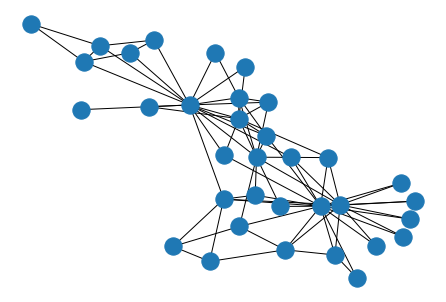

In [5]:
nx.draw(graph,with_label=True)

### 1) Adjacency Matrix

In [6]:
A = nx.to_numpy_matrix(graph, nodelist=sorted(graph.nodes()))

In [7]:
A

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

### 2). Input Word Vector ( One-Hot encoded )

In [8]:
OH = np.identity(34)

In [9]:
OH

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## 2. Random Walk

In [12]:
def random_step(i,w):
    walk_list = []
    walk_list.append(i)
    for k in range(w-1):
        ad = np.nonzero(A[i])[1] # i와 인접한 vertex들의 list
        rand = random.choice(ad) # 그 list중 랜덤하게 하나 고르기
        walk_list.append(rand)
        i = rand
    return walk_list

In [13]:
random_step(3,10)

[3, 7, 0, 12, 3, 1, 21, 1, 17, 1]

## 3. Binary Tree for Hierarchical Softmax

In [14]:
class Node:
    def __init__(self,value):
        self.value = value
        self.left = None
        self.right = None

In [15]:
class BinaryTree:
    def __init__(self,head):
        self.head = head
        self.left= None
        self.right= None
    
    def insert(self,key_val):
        key = key_val[0]
        self.current_node = self.head
        
        while True:
            if key < self.current_node.value[0]:
                if self.current_node.left != None:
                    self.current_node = self.current_node.left
                else :
                    self.current_node.left = Node(key_val)
                    break
            else :
                if self.current_node.right !=None:
                    self.current_node = self.current_node.right
                else :
                    self.current_node.right = Node(key_val)
                    break
    
    def path(self,key):        
        self.current_node = self.head
        path_list = []
        way_list = []
        while key>1:
            if key%2 ==0:
                path_list.append(int(key/2))
                way_list.append(1)
            else :
                path_list.append(int((key-1)/2))
                way_list.append(-1)
            key = int(key/2)
        return np.flip(path_list), np.flip(way_list)

### Make Nodes for 34 Words ( Total : 67 )

In [16]:
node_dicts = {}

node_k = range(1,68)
node_v = np.random.normal(0.5,0.1,(67,2))

for i in node_k:
    for x in node_v:
        node_dicts[i] = x

In [20]:
node_dicts

{1: array([0.59719917, 0.38779335]),
 2: array([0.59719917, 0.38779335]),
 3: array([0.59719917, 0.38779335]),
 4: array([0.59719917, 0.38779335]),
 5: array([0.59719917, 0.38779335]),
 6: array([0.59719917, 0.38779335]),
 7: array([0.59719917, 0.38779335]),
 8: array([0.59719917, 0.38779335]),
 9: array([0.59719917, 0.38779335]),
 10: array([0.59719917, 0.38779335]),
 11: array([0.59719917, 0.38779335]),
 12: array([0.59719917, 0.38779335]),
 13: array([0.59719917, 0.38779335]),
 14: array([0.59719917, 0.38779335]),
 15: array([0.59719917, 0.38779335]),
 16: array([0.59719917, 0.38779335]),
 17: array([0.59719917, 0.38779335]),
 18: array([0.59719917, 0.38779335]),
 19: array([0.59719917, 0.38779335]),
 20: array([0.59719917, 0.38779335]),
 21: array([0.59719917, 0.38779335]),
 22: array([0.59719917, 0.38779335]),
 23: array([0.59719917, 0.38779335]),
 24: array([0.59719917, 0.38779335]),
 25: array([0.59719917, 0.38779335]),
 26: array([0.59719917, 0.38779335]),
 27: array([0.5971991

In [21]:
head = Node(list(node_dicts.items())[0])
H_Softmax = BinaryTree(head)

In [255]:
V = 34
for num in range(1,2*V-1):
    k_v = list(node_dicts.items())[num]
    H_Softmax.insert(k_v)

## 4. Hierarchical Softmax

### Define Functions

In [258]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [260]:
def index2key(num):
    return num+34

def key2index(num):
    return num-34

In [261]:
def ReLU(x):
    return np.maximum(x,0)

### DeepWalk with Hierarchical Softmax

In [263]:
def Deepwalk_HS(input_word,reduced_dim,window_size,walk_length,lr,epoch):
    W1 = np.random.normal(0.5,0.1,(input_word.shape[0],reduced_dim))
    for _ in range(epoch):
        for index in range(input_word.shape[0]):
            RW_ = random_step(index,walk_length)
            for w in range(len(RW_)):
                RW = RW_[w : w+2*window_size+1]
                for i in range(len(RW)):
                    h = np.matmul(W1.T, input_word[RW[i]])
                    RW_except_i = RW[:i] + RW[i+1:]
                    for j in RW_except_i :
                        total_list = []
                        j = index2key(j)
                        for k in range(len(H_Softmax.path(j)[0])):
                            vector_value = node_dicts[H_Softmax.path(j)[0][k]]
                            vector_way = H_Softmax.path(j)[1][k]
                            result = np.matmul(vector_value*vector_way, h)
                            result2 = sigmoid(result)
                            total_list.append(result2)

                        # Output - Hidden
                        for k in range(len(H_Softmax.path(j)[0])-1, -1, -1):  
                            error = (total_list[k] - ReLU(H_Softmax.path(j)[1][k]))
                            node_dicts[H_Softmax.path(j)[0][k]] -= lr*error*h

                        # Hidden - Input
                        total_sum = 0
                        for m in range(len(H_Softmax.path(j)[0])):
                            error = (total_list[m] - ReLU(H_Softmax.path(j)[1][m]))
                            v_ = node_dicts[H_Softmax.path(j)[0][m]]
                            total_sum += error * v_
                        W1[key2index(j)] -= lr*total_sum
    return W1

In [265]:
Deepwalk_HS(OH,2,3,18,0.01,3).round(3)

array([[0.483, 0.6  ],
       [0.379, 0.49 ],
       [0.44 , 0.586],
       [0.431, 0.407],
       [0.516, 0.452],
       [0.638, 0.5  ],
       [0.58 , 0.475],
       [0.57 , 0.546],
       [0.377, 0.491],
       [0.608, 0.604],
       [0.632, 0.567],
       [0.641, 0.474],
       [0.363, 0.551],
       [0.666, 0.408],
       [0.697, 0.475],
       [0.699, 0.653],
       [0.405, 0.597],
       [0.437, 0.374],
       [0.564, 0.424],
       [0.368, 0.415],
       [0.399, 0.433],
       [0.733, 0.564],
       [0.561, 0.391],
       [0.647, 0.563],
       [0.603, 0.453],
       [0.507, 0.607],
       [0.563, 0.572],
       [0.432, 0.654],
       [0.376, 0.499],
       [0.404, 0.441],
       [0.536, 0.528],
       [0.533, 0.436],
       [0.431, 0.726],
       [0.36 , 0.603]])

# 4. Result

In [271]:
w1 = Deepwalk_HS(OH,2,4,15,0.01,5)

In [273]:
Emb = np.matmul(OH,w1)

In [274]:
Emb_df = pd.DataFrame({'X':Emb[:,0], 'Y':Emb[:,1],'Label':range(1,35)})

blue = [1,2,3,4,5,6,7,8,9,11,12,13,14,17,18,20,22]
red = list(set(range(0,34))-set(blue))

Emb_df.loc[Emb_df.Label.isin(blue),'Color']=1
Emb_df.loc[Emb_df.Label.isin(red),'Color']=0

### Visualization